In [1]:
using FurutaRL
using ReinforcementLearning
using Flux
using Random
using Plots
using StableRNGs
using IntervalSets
using CUDA
using Statistics
using BSON: @save, @load
using BSON
using Logging
using TensorBoardLogger: TBLogger
using CircularArrayBuffers
using Dates
using Distributions
using ProgressBars
CUDA.allowscalar(false)

In [2]:
function evaluate(θ)
    t_start = ceil(Int, length(θ)/2)
    success = true
    for k = t_start:length(θ)
        if abs(θ[k]) > π/2
            success = false
            break
        end
    end
    success
end 

evaluate (generic function with 1 method)

In [3]:
function test(agent; σ=0.0, τ_C=0.0076, τ_S=0.008)
    T = Float32
    Ts = T(0.006)
    Tf = 5
    rng = MersenneTwister() #StableRNG(0)
    inner_env = FurutaEnv(dt = Ts, max_torque=T(0.04), max_steps = ceil(Int, Tf/Ts), T = T, rng = rng, tau_C=T(τ_C), tau_S=T(τ_S))
    A = action_space(inner_env)
    low = A.left
    high = A.right

    env = ActionTransformedEnv(
        inner_env;
        action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
    )
    
    reset!(env.env, [π, 0, 0, 0])
    t, done = 0, false
    X = []
    c_reward = 0
    while !done && t <= 833*2
        s0 = env.env.state 
        push!(X, s0)
        s0 += rand(Normal(0, σ), 4)
        s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        a = action(agent, s; training=false)
        env(a)
        t += 1
        c_reward += reward(env)
    end
    θ = [rem2pi(x[1], RoundNearest) for x in X]
    evaluate(θ)
end

test (generic function with 1 method)

In [4]:
function pgd(agent::DemoAgent, x0; ϵ = 0.1, steps = 10)
    A = agent.policy.behavior_actor.model
    C = agent.policy.target_critic.model
    
    s0 = [sin(x0[1]), cos(x0[1]), x0[2:end]...]
    s0 = send_to_device(device(A), s0)
    a = A(s0)
    
    x = copy(x0)
    α = 2.5*ϵ/steps
    for k in 1:steps
        grad = gradient(Flux.params(x)) do
            s = [sin(x[1]), cos(x[1]), x[2:end]...]
            s = send_to_device(device(A), s)
            mean(C(vcat(s0, A(s))))
        end
        x = x - α*sign.(grad[x]) #MIND THE SIGN
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
    end
    cpu(x)
end

pgd (generic function with 1 method)

In [7]:
total_results = Dict()
σs = 0.0:0.01:0.3
N_TRIALS = 30
for pgd_level in 0.15#0.025:0.025:0.15 #(0.0025, 0.0050, 0.0075, 0.0100)
    #pgd_level = 0.0025
    agent_results = Dict()
    for agent_number in 1:5
        IJulia.clear_output(true)
        println("PGD level: " * string(pgd_level))
        println("Agent number " * string(agent_number))
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "stat_agents_4/" * pgd_string * "pgd"
        if agent_number in 1:9
            agent_name = agent_name * "0" * string(agent_number) * ".bson"
        else
            agent_name = agent_name * string(agent_number) * ".bson"
        end
        @load agent_name model
        agent = gpu(model)
    
        success_percentages = []
    
        for σ in σs
            iter = tqdm(1:N_TRIALS)
            #print("σ = " * string(σ))
            results = []
        
            for i in iter
                result = test(agent, σ=σ) #true = success, false = failure
                push!(results, result)
                set_description(iter, "σ = " * string(σ))
            end
        
            percentage = sum(results)/N_TRIALS
            push!(success_percentages, percentage)
        end
    
        agent_results[agent_number] = success_percentages
    end
    agent_results
    total_results[pgd_level] = agent_results
end

PGD level: 0.15
Agent number 5
σ = 0.0 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]15/30 [00:05<00:05, 2.8 it/s]17/30 [00:06<00:05, 2.8 it/s]21/30 [00:07<00:03, 2.9 it/s]26/30 [00:09<00:01, 2.9 it/s]
σ = 0.01 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]5/30 [00:02<00:11, 2.3 it/s]9/30 [00:03<00:08, 2.6 it/s]11/30 [00:04<00:07, 2.6 it/s]25/30 [00:08<00:02, 2.8 it/s]
σ = 0.02 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]9/30 [00:03<00:08, 2.6 it/s]15/30 [00:05<00:05, 2.8 it/s]17/30 [00:06<00:05, 2.8 it/s]22/30 [00:07<00:03, 2.8 it/s]24/30 [00:08<00:02, 2.9 it/s]26/30 [00:09<00:01, 2.9 it/s]
σ = 0.03 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]17/30 [00:06<00:05, 2.8 it/s]26/30 [00:09<00:01, 2.9 it/s]
σ = 0.04 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.8 it/s]2/30 [00:01<00:23, 1.2 it/s]6/30 [00:02<00:10, 2.4 it/s]7/30 [00:02<00:09, 2.5 it/s]18/30 [00:06<00:04, 

In [8]:
@load "BASELINE4.BSON" model
agent = gpu(model)
baseline4_results = []
N_TRIALS = 30
for σ in σs
    iter = tqdm(1:N_TRIALS)
    #print("σ = " * string(σ))
    results = []
    for i in iter
        result = test(agent, σ=σ) #true = success, false = failure
        push!(results, result)
        set_description(iter, "σ = " * string(σ))
    end
        
    percentage = sum(results)/N_TRIALS
    push!(baseline4_results, percentage)
end

σ = 0.0 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 2.8 it/s]4/30 [00:01<00:12, 2.3 it/s]8/30 [00:03<00:10, 2.3 it/s]11/30 [00:04<00:08, 2.5 it/s]13/30 [00:05<00:07, 2.6 it/s]15/30 [00:05<00:06, 2.6 it/s]19/30 [00:07<00:04, 2.7 it/s]27/30 [00:10<00:01, 2.7 it/s]28/30 [00:10<00:01, 2.8 it/s]
σ = 0.01 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.8 it/s]9/30 [00:03<00:09, 2.4 it/s]10/30 [00:04<00:08, 2.5 it/s]11/30 [00:04<00:07, 2.6 it/s]12/30 [00:04<00:07, 2.6 it/s]25/30 [00:09<00:02, 2.8 it/s]
σ = 0.02 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.8 it/s]1/30 [00:00<Inf:Inf, 0.0 it/s]5/30 [00:02<00:11, 2.2 it/s]6/30 [00:02<00:10, 2.4 it/s]7/30 [00:02<00:09, 2.5 it/s]8/30 [00:03<00:09, 2.6 it/s]14/30 [00:05<00:06, 2.7 it/s]18/30 [00:06<00:04, 2.7 it/s]
σ = 0.03 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.8 it/s]4/30 [00:02<00:13, 2.0 it/s]5/30 [00:02<00:11, 2.2 it/s]16/30 [00:05<00:05, 2.7 it/s]17/30 [00:06<00:05

In [11]:
@load "BASELINE10k.BSON" model
agent = gpu(model)
baseline10k_results = []
N_TRIALS = 30
for σ in σs
    iter = tqdm(1:N_TRIALS)
    #print("σ = " * string(σ))
    results = []
    for i in iter
        result = test(agent, σ=σ) #true = success, false = failure
        push!(results, result)
        set_description(iter, "σ = " * string(σ))
    end
        
    percentage = sum(results)/N_TRIALS
    push!(baseline10k_results, percentage)
end

σ = 0.0 100.0%┣██████████████████████████████████┫ 30/30 [00:18<00:00, 1.6 it/s]7/30 [00:05<00:18, 1.3 it/s]19/30 [00:11<00:07, 1.6 it/s]25/30 [00:15<00:03, 1.6 it/s]26/30 [00:16<00:03, 1.6 it/s]29/30 [00:18<00:01, 1.6 it/s]
σ = 0.025 100.0%┣████████████████████████████████┫ 30/30 [00:15<00:00, 2.0 it/s]4/30 [00:02<00:17, 1.5 it/s]7/30 [00:04<00:14, 1.7 it/s]9/30 [00:04<00:12, 1.8 it/s]11/30 [00:05<00:10, 1.9 it/s]13/30 [00:06<00:09, 1.9 it/s]16/30 [00:08<00:07, 1.9 it/s]19/30 [00:09<00:06, 2.0 it/s]21/30 [00:10<00:05, 1.9 it/s]25/30 [00:12<00:03, 2.0 it/s]
σ = 0.05 100.0%┣█████████████████████████████████┫ 30/30 [00:15<00:00, 2.0 it/s]2/30 [00:01<00:31, 0.9 it/s]12/30 [00:06<00:10, 1.9 it/s]18/30 [00:09<00:06, 1.9 it/s]26/30 [00:13<00:02, 2.0 it/s]27/30 [00:13<00:02, 2.0 it/s]28/30 [00:14<00:01, 2.0 it/s]┫ 29/30 [00:14<00:01, 2.0 it/s]
σ = 0.075 100.0%┣████████████████████████████████┫ 30/30 [00:15<00:00, 2.0 it/s]1/30 [00:01<Inf:Inf, 0.0 it/s]5/30 [00:02<00:14, 1.7 it/s]14/30 [00:07<

In [9]:
agent = FurutaPolicy()
classical_results = []
N_TRIALS = 30
for σ in σs
    iter = tqdm(1:N_TRIALS)
    #print("σ = " * string(σ))
    results = []
    for i in tqdm(1:N_TRIALS)
        result = test(agent, σ=σ) #true = success, false = failure
        push!(results, result)
        set_description(iter, "σ = " * string(σ))
    end
        
    percentage = sum(results)/N_TRIALS
    push!(classical_results, percentage)
end

100.0%┣█████████████████████████████████████████┫ 30/30 [00:00<00:00, 71.9 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 118.0 it/s]1/30 [00:00<Inf:Inf, 0.0 it/s]19/30 [00:00<00:00, 101.2 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 135.0 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 128.2 it/s]11/30 [00:00<00:00, 90.8 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 120.1 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 127.1 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 136.1 it/s]19/30 [00:00<00:00, 106.6 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 125.5 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 125.6 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 139.2 it/s]
100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00,

In [7]:
new_results = Dict()
σs = 0.0:0.05:0.3
N_TRIALS = 30
for pgd_level in 0.25 #0.1:0.1:0.4 #(0.0025, 0.0050, 0.0075, 0.0100)
    #pgd_level = 0.0025
    agent_results = Dict()
    for agent_number in 1:5
        IJulia.clear_output(true)
        println("PGD level: " * string(pgd_level))
        println("Agent number " * string(agent_number))
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "stat_agents_3/" * pgd_string * "pgd"
        if agent_number in 1:9
            agent_name = agent_name * "0" * string(agent_number) * ".bson"
        else
            agent_name = agent_name * string(agent_number) * ".bson"
        end
    
        @load agent_name model
        agent = gpu(model)
    
        success_percentages = []
    
        for σ in σs
            iter = tqdm(1:N_TRIALS)
            #print("σ = " * string(σ))
            results = []
        
            for i in iter
                result = test(agent, σ=σ) #true = success, false = failure
                push!(results, result)
                set_description(iter, "σ = " * string(σ))
            end
        
            percentage = sum(results)/N_TRIALS
            push!(success_percentages, percentage)
        end
    
        agent_results[agent_number] = success_percentages
    end
    agent_results
    new_results[pgd_level] = agent_results
end

PGD level: 0.25
Agent number 5
σ = 0.0 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 3.0 it/s]4/30 [00:01<00:11, 2.4 it/s]8/30 [00:03<00:08, 2.6 it/s]10/30 [00:03<00:07, 2.8 it/s]12/30 [00:04<00:06, 2.8 it/s]22/30 [00:07<00:03, 3.0 it/s]
σ = 0.05 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]4/30 [00:01<00:12, 2.2 it/s]5/30 [00:02<00:11, 2.4 it/s]14/30 [00:05<00:06, 2.8 it/s]25/30 [00:08<00:02, 2.8 it/s]27/30 [00:09<00:01, 2.9 it/s]29/30 [00:10<00:00, 2.9 it/s]
σ = 0.1 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 3.0 it/s]7/30 [00:02<00:09, 2.6 it/s]10/30 [00:03<00:07, 2.8 it/s]11/30 [00:04<00:07, 2.7 it/s]15/30 [00:05<00:05, 2.8 it/s]17/30 [00:05<00:04, 2.9 it/s]20/30 [00:07<00:03, 2.9 it/s]29/30 [00:10<00:00, 2.9 it/s]
σ = 0.15 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]2/30 [00:01<00:19, 1.5 it/s]4/30 [00:01<00:11, 2.3 it/s]7/30 [00:02<00:09, 2.5 it/s]19/30 [00:06<00:04, 2.9 it/s]29/30 [00:09<00:

In [14]:
anti_results = Dict()
σs = 0.0:0.05:0.3
N_TRIALS = 30
for pgd_level in 0.25 #0.1:0.1:0.4 #(0.0025, 0.0050, 0.0075, 0.0100)
    #pgd_level = 0.0025
    agent_results = Dict()
    for agent_number in 1:4
        IJulia.clear_output(true)
        println("PGD level: " * string(pgd_level))
        println("Agent number " * string(agent_number))
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "anti_training_2/" * pgd_string * "pgd"
        if agent_number in 1:9
            agent_name = agent_name * "0" * string(agent_number) * ".bson"
        else
            agent_name = agent_name * string(agent_number) * ".bson"
        end
    
        @load agent_name model
        agent = gpu(model)
    
        success_percentages = []
    
        for σ in σs
            iter = tqdm(1:N_TRIALS)
            #print("σ = " * string(σ))
            results = []
        
            for i in iter
                result = test(agent, σ=σ) #true = success, false = failure
                push!(results, result)
                set_description(iter, "σ = " * string(σ))
            end
        
            percentage = sum(results)/N_TRIALS
            push!(success_percentages, percentage)
        end
    
        agent_results[agent_number] = success_percentages
    end
    agent_results
    anti_results[pgd_level] = agent_results
end

PGD level: 0.25
Agent number 4
σ = 0.0 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]2/30 [00:01<00:18, 1.5 it/s]4/30 [00:01<00:11, 2.4 it/s]10/30 [00:03<00:07, 2.7 it/s]14/30 [00:05<00:06, 2.8 it/s]16/30 [00:05<00:05, 2.9 it/s]17/30 [00:06<00:05, 2.8 it/s]26/30 [00:09<00:01, 2.9 it/s]
σ = 0.05 100.0%┣█████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]2/30 [00:01<00:18, 1.5 it/s]13/30 [00:04<00:06, 2.8 it/s]14/30 [00:05<00:06, 2.8 it/s]17/30 [00:06<00:05, 2.9 it/s]19/30 [00:06<00:04, 2.8 it/s]21/30 [00:07<00:03, 2.8 it/s]24/30 [00:08<00:02, 2.9 it/s]25/30 [00:08<00:02, 2.9 it/s]
σ = 0.1 100.0%┣██████████████████████████████████┫ 30/30 [00:10<00:00, 2.9 it/s]3/30 [00:01<00:13, 2.1 it/s]6/30 [00:02<00:09, 2.6 it/s]8/30 [00:03<00:08, 2.8 it/s]11/30 [00:04<00:07, 2.7 it/s]15/30 [00:05<00:05, 2.8 it/s]16/30 [00:05<00:05, 2.9 it/s]19/30 [00:06<00:04, 2.8 it/s]21/30 [00:07<00:03, 2.8 it/s]25/30 [00:08<00:02, 2.9 it/s]28/30 [00:09<00:01, 2.9 it/s]
σ = 0.1

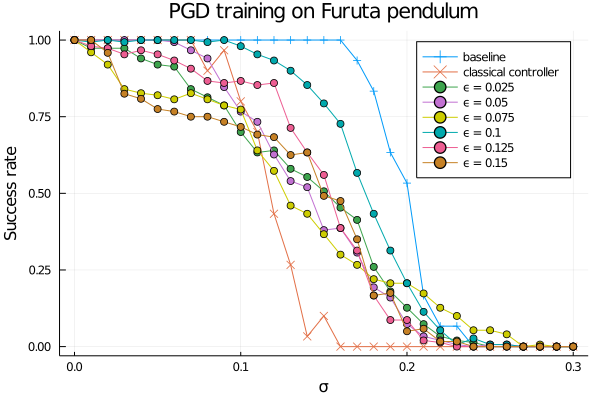

In [57]:
p1 = plot()
#for (level, agent_results) in total_results
plot!(p1, σs, baseline4_results, marker=:+, label="baseline")
#plot!(p1, σs, baseline10k_results, marker=:+, label="baseline10k")
plot!(p1, σs, classical_results, marker=:x, label="classical controller")
for level in 0.025:0.025:0.15
    agent_results = total_results[level]
    average = zeros(length(agent_results[1]))
    for (k, resultvec) in agent_results
        average += resultvec
    end
    average = average/length(agent_results)
    if level == 0.075
        plot!(p1, σs, average, ylim=[0, 1], marker=:circle, legend = :topright, label = "ϵ = "*string(level), 
            xlabel="σ", ylabel="Success rate", title="PGD training on Furuta pendulum", color=:yellow3)
    else
        plot!(p1, σs, average, ylim=[0, 1], marker=:circle, legend = :topright, label = "ϵ = "*string(level), 
            xlabel="σ", ylabel="Success rate", title="PGD training on Furuta pendulum")
    end
end
# for (level, agent_results) in anti_results
#     average = zeros(length(agent_results[1]))
#     for (k, resultvec) in agent_results
#         average += resultvec
#     end
#     average = average/length(agent_results)
#     plot!(p1, σs, average, ylim=[0, 1], marker=:square, legend = :topright, label = "anti"*string(level), 
#         xlabel="σ", ylabel="Success rate", title="Success rate of PGD training")
# end

display(p1)

In [58]:
savefig(p1, "figures/Furuta_pgd_results.svg")

In [21]:
agent_results = total_results[0.15]
# for r in values(agent_results)
#     println(r)
# end


Dict{Any,Any} with 5 entries:
  4 => Any[1.0, 1.0, 1.0, 0.933333, 1.0, 0.9, 0.933333, 1.0, 0.933333, 1.0  …  …
  2 => Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, …
  3 => Any[1.0, 1.0, 0.733333, 0.3, 0.233333, 0.0666667, 0.0666667, 0.0, 0.0333…
  5 => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0333333, 0.0, 0.0333333, 0.0  …  0.0…
  1 => Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.233333, 0.1, …

In [8]:
vals = []
for i in 1:5
    v = total_results[0.15][i]
    println(string(i)*": "*string(mean(v)))
    push!(vals, mean(v))
end
println("mean: "*string(mean(vals)))
println("std:  "*string(std(vals)))

1: 0.5913978494623657
2: 0.5784946236559141
3: 0.11612903225806452
4: 0.4505376344086022
5: 0.478494623655914
mean: 0.4430107526881721
std:  0.19270575236621335


In [92]:
mean(baseline4_results)

0.6526881720430108

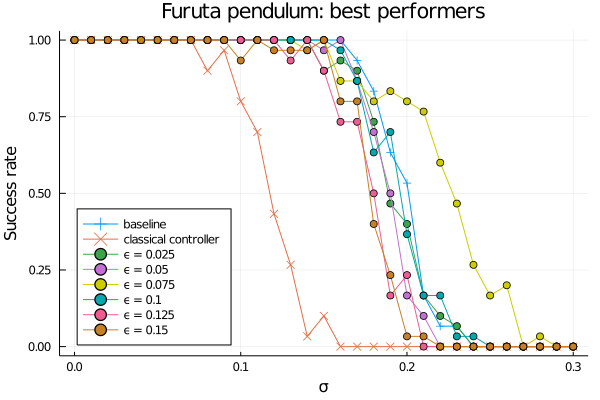

In [80]:
p1 = plot()
plot!(p1, σs, baseline4_results, marker=:+, label="baseline")
plot!(p1, σs, classical_results, marker=:x, label="classical controller")
plot!(p1, σs, total_results[0.025][2], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.025", 
        xlabel="σ", ylabel="Success rate", title="Furuta pendulum: best performers")
plot!(p1, σs, total_results[0.05][5], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.05")
plot!(p1, σs, total_results[0.075][2], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.075", 
    color=:yellow3)
plot!(p1, σs, total_results[0.1][2], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.1")
plot!(p1, σs, total_results[0.125][2], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.125")
plot!(p1, σs, total_results[0.15][2], ylim=[0, 1], marker=:circle, legend = :bottomleft, label = "ϵ = 0.15")

display(p1)

In [81]:
savefig(p1, "figures/Furuta_best_performers.svg")

In [14]:
total_results = Dict()
τs= 0.01:0.005:0.5
N_TRIALS = 10
for pgd_level in (0.0025, 0.0050, 0.0075, 0.0100)
    #pgd_level = 0.0025
    agent_results = Dict()
    for agent_number in 1:20
        IJulia.clear_output(true)
        println("PGD level: " * string(pgd_level))
        println("Agent number " * string(agent_number))
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "stat_agents_2/" * pgd_string * "pgd"
        if agent_number in 1:9
            agent_name = agent_name * "0" * string(agent_number) * ".bson"
        else
            agent_name = agent_name * string(agent_number) * ".bson"
        end
    
        @load agent_name model
        agent = gpu(model)
    
        success_percentages = []
    
        for τ in τs
            iter = tqdm(1:N_TRIALS)
            #print("σ = " * string(σ))
            results = []
        
            for i in iter
                result = test(agent, τ_S=τ, τ_C=τ) #true = success, false = failure
                push!(results, result)
                set_description(iter, "τ = " * string(τ))
            end
        
            percentage = sum(results)/N_TRIALS
            push!(success_percentages, percentage)
        end
    
        agent_results[agent_number] = success_percentages
    end
    agent_results
    total_results[pgd_level] = agent_results
end

PGD level: 0.01
Agent number 20
τ = 0.01 100.0%┣█████████████████████████████████┫ 10/10 [00:04<00:00, 2.5 it/s]1/10 [00:00<Inf:Inf, 0.0 it/s]3/10 [00:01<00:04, 1.9 it/s]7/10 [00:02<00:01, 2.5 it/s]
τ = 0.02 100.0%┣█████████████████████████████████┫ 10/10 [00:03<00:00, 2.6 it/s]1/10 [00:00<Inf:Inf, 0.0 it/s]4/10 [00:01<00:03, 2.3 it/s]6/10 [00:02<00:02, 2.5 it/s]
τ = 0.03 100.0%┣█████████████████████████████████┫ 10/10 [00:03<00:00, 2.6 it/s]3/10 [00:01<00:04, 1.9 it/s]6/10 [00:02<00:02, 2.4 it/s]8/10 [00:03<00:01, 2.5 it/s]
τ = 0.04 100.0%┣█████████████████████████████████┫ 10/10 [00:04<00:00, 2.5 it/s]5/10 [00:02<00:02, 2.2 it/s]8/10 [00:03<00:01, 2.5 it/s]9/10 [00:03<00:00, 2.6 it/s]
τ = 0.05 100.0%┣█████████████████████████████████┫ 10/10 [00:03<00:00, 2.6 it/s]4/10 [00:01<00:03, 2.2 it/s]8/10 [00:03<00:01, 2.5 it/s]
τ = 0.06 100.0%┣█████████████████████████████████┫ 10/10 [00:03<00:00, 2.6 it/s]1/10 [00:00<Inf:Inf, 0.0 it/s]3/10 [00:01<00:04, 1.9 it/s]6/10 [00:02<00:02, 2.4 it/s]9

In [15]:
@load "BASELINE4.BSON" model
agent = gpu(model)
baseline_results = []
N_TRIALS = 10
for τ in τs
    iter = tqdm(1:N_TRIALS)
    #print("σ = " * string(σ))
    results = []
    for i in iter
        result = test(agent, τ_S=τ, τ_C=τ) #true = success, false = failure
        push!(results, result)
        set_description(iter, "τ = " * string(τ))
    end
        
    percentage = sum(results)/N_TRIALS
    push!(baseline_results, percentage)
end

τ = 0.01 100.0%┣█████████████████████████████████┫ 10/10 [00:07<00:00, 1.2 it/s]3/10 [00:03<00:09, 0.8 it/s]8/10 [00:06<00:02, 1.1 it/s]
τ = 0.02 100.0%┣█████████████████████████████████┫ 10/10 [00:07<00:00, 1.4 it/s]1/10 [00:01<Inf:Inf, 0.0 it/s]3/10 [00:02<00:08, 0.9 it/s]6/10 [00:04<00:03, 1.3 it/s]9/10 [00:06<00:01, 1.4 it/s]
τ = 0.03 100.0%┣█████████████████████████████████┫ 10/10 [00:06<00:00, 1.5 it/s]4/10 [00:02<00:05, 1.3 it/s]7/10 [00:04<00:02, 1.5 it/s]
τ = 0.04 100.0%┣█████████████████████████████████┫ 10/10 [00:06<00:00, 1.5 it/s]2/10 [00:01<00:10, 0.8 it/s]
τ = 0.05 100.0%┣█████████████████████████████████┫ 10/10 [00:06<00:00, 1.4 it/s]5/10 [00:04<00:04, 1.1 it/s]
τ = 0.06 100.0%┣█████████████████████████████████┫ 10/10 [00:06<00:00, 1.5 it/s]6/10 [00:04<00:03, 1.3 it/s]7/10 [00:04<00:02, 1.4 it/s]
τ = 0.07 100.0%┣█████████████████████████████████┫ 10/10 [00:06<00:00, 1.5 it/s]1/10 [00:01<Inf:Inf, 0.0 it/s]4/10 [00:02<00:05, 1.3 it/s]
τ = 0.08 100.0%┣█████████████████████

In [16]:
agent = FurutaPolicy()
classical_results = []
N_TRIALS = 10
for τ in τs
    iter = tqdm(1:N_TRIALS)
    #print("σ = " * string(σ))
    results = []
    for i in tqdm(1:N_TRIALS)
        result = test(agent, τ_S=τ, τ_C=τ) #true = success, false = failure
        push!(results, result)
        set_description(iter, "τ = " * string(τ))
    end
        
    percentage = sum(results)/N_TRIALS
    push!(classical_results, percentage)
end

100.0%┣█████████████████████████████████████████┫ 10/10 [00:01<00:00, 10.7 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 74.5 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 62.8 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 64.9 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 76.0 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 74.4 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 70.4 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 74.8 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 76.3 it/s]
100.0%┣█████████████████████████████████████████┫ 10/10 [00:00<00:00, 68.8 it/s]


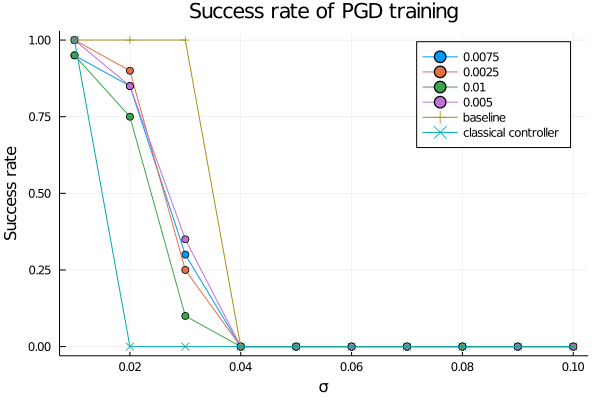

In [18]:
p1 = plot()
for (level, agent_results) in total_results
    average = zeros(length(agent_results[1]))
    for (k, resultvec) in agent_results
        average += resultvec
    end
    average = average/length(agent_results)
    plot!(p1, τs, average, ylim=[0, 1], marker=:circle, legend = :topright, label = string(level), 
        xlabel="τ", ylabel="Success rate", title="Success rate of PGD training")
end
plot!(p1, τs, baseline_results, marker=:+, label="baseline")
plot!(p1, τs, classical_results, marker=:x, label="classical controller")
display(p1)

In [4]:
function evaluate_grads(agent, X)
    A = agent.policy.behavior_actor.model
    max_grad = [0, [], 0]
    for s0 in X
        x = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        u = 0
        g = gradient(Flux.params(x)) do
            xd = send_to_device(device(A), x)
            u = mean(A(xd))
        end
        if maximum(abs.(g[x])) > maximum(abs.(max_grad[1]))
            max_grad = [g[x], x, u]
        end
    end
    max_grad
end

evaluate_grads (generic function with 1 method)

In [5]:
function test_grads(agent)
    T = Float32
    Ts = T(0.006)
    Tf = 5
    rng = MersenneTwister() #StableRNG(0)
    inner_env = FurutaEnv(dt = Ts, max_torque=T(0.04), max_steps = ceil(Int, Tf/Ts), T = T, rng = rng)
    A = action_space(inner_env)
    low = A.left
    high = A.right

    env = ActionTransformedEnv(
        inner_env;
        action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
    )
    
    reset!(env.env, [π, 0, 0, 0])
    t, done = 0, false
    X = []
    c_reward = 0
    while !done && t <= 833*2
        s0 = env.env.state 
        push!(X, s0)
        s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        a = action(agent, s; training=false)
        env(a)
        t += 1
        c_reward += reward(env)
    end
    X
    evaluate_grads(agent, X)
end

test_grads (generic function with 1 method)

In [6]:
total_results = Dict()
N_TRIALS = 30
for pgd_level in 0.01 #(0.0025, 0.0050, 0.0075, 0.0100)
    #pgd_level = 0.0025
    agent_results = Dict()
    for agent_number in 1:20
        IJulia.clear_output(true)
        println("PGD level: " * string(pgd_level))
        println("Agent number " * string(agent_number))
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "stat_agents_2/" * pgd_string * "pgd"
        if agent_number in 1:9
            agent_name = agent_name * "0" * string(agent_number) * ".bson"
        else
            agent_name = agent_name * string(agent_number) * ".bson"
        end
    
        @load agent_name model
        agent = gpu(model)
    
        max_grad = []
    
        #iter = tqdm(1:N_TRIALS)
        #print("σ = " * string(σ))
        
        result = test_grads(agent) #true = success, false = failure
        #push!(max_grads, result)
    
        agent_results[agent_number] = result
    end
    agent_results
    total_results[pgd_level] = agent_results
end

PGD level: 0.01
Agent number 20


In [8]:
total_results[0.01]
for (agent, res) in total_results[0.01]
    print("agent "*string(agent)*": ")
    println(res)
end

agent 18: Any[Float32[37.787502, 12.16323, 1.848209, 7.038211, 0.8474071], Float32[0.053095095, 0.99858946, 0.7217991, -0.6229282, -1.7875521], 0.03399171f0]
agent 2: Any[Float32[25.378557, -4.205901, 0.9965482, 2.894919, 0.4551811], Float32[-0.030854398, 0.9995239, -0.012357621, 0.6801352, 1.2742445], 0.15775622f0]
agent 16: Any[Float32[30.816954, -0.2805785, 1.2645321, 2.5833151, 0.057274044], Float32[-0.12940712, 0.9915916, -0.75971514, 2.960225, 10.556204], -0.032385796f0]
agent 11: Any[Float32[23.504135, -2.1391237, 2.008992, 3.1376827, 1.1178057], Float32[0.0045373756, 0.9999897, 0.07026326, -0.20144314, -0.066081636], -0.010009061f0]
agent 7: Any[Float32[21.938593, 0.57022053, 0.8838312, 1.3664371, 0.38065436], Float32[0.01912447, 0.99981713, -0.07903101, -3.8675258, -0.32397574], -0.17211965f0]
agent 9: Any[Float32[27.390512, 6.942581, 1.874422, 3.4281356, 0.75208753], Float32[0.2526874, 0.96754795, -0.4952366, -2.9063177, -3.2599118], 0.13215423f0]
agent 10: Any[Float32[4.3862

In [88]:
x = []
y = []
for (level, agent_results) in total_results
    push!(x, level)
    av = 0
    #println("level: "*string(level))
    for results in agent_results
        res = maximum(results[2][1])
        av += res
        #println(res)
    end
    av = av/length(agent_results)
    push!(y, av)
end
@load "BASELINE4.BSON" model
agent = gpu(model)
res = test_grads(agent)
val_b = maximum(res[1])

println("baseline: " * string(val_b))
for (level, value) in zip(x, y)
    println("level " * string(level) * ": value " * string(value))
end

baseline: 18.977768
level 0.07: value 22.357544
level 0.1: value 23.910555
level 0.09: value 24.806286
level 0.06: value 27.322693
level 0.05: value 22.896194
level 0.08: value 21.319181


In [80]:
@load "BASELINE4.BSON" model
agent = gpu(model)
res = test_grads(agent)
val = maximum(res[1])
# A = agent.policy.behavior_actor.model
# for x in X
#     g = gradient(Flux.params(x)) do
#         s = [sin(x[1]), cos(x[1]), x[2:4]...]
#         s = send_to_device(device(A), s)
#         u = mean(A(s))
#     end
#     println(g[x])
# end



18.977768f0

In [5]:
function twiny(sp::Plots.Subplot)
    sp[:top_margin] = max(sp[:top_margin], 30Plots.px)
    plot!(sp.plt, inset = (sp[:subplot_index], bbox(0,0,1,1)))
    twinsp = sp.plt.subplots[end]
    twinsp[:xaxis][:mirror] = true
    twinsp[:background_color_inside] = RGBA{Float64}(0,0,0,0)
    Plots.link_axes!(sp[:yaxis], twinsp[:yaxis])
    twinsp
end
twiny(plt::Plots.Plot = current()) = twiny(plt[1])

twiny (generic function with 3 methods)

In [27]:
@load "BASELINE4.BSON" model
agent = gpu(model)
es = 0.0:0.01:0.4
T = Float32
Ts = T(0.006)
Tf = 5
rng = MersenneTwister() #StableRNG(0)
inner_env = FurutaEnv(dt = Ts, max_torque=T(0.04), max_steps = ceil(Int, Tf/Ts), T = T, rng = rng)
A = action_space(inner_env)
low = A.left
high = A.right

env = ActionTransformedEnv(
    inner_env;
    action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
)
    
res_wn = []
res_pgd = []
nans = []
for e in es
    σ = e
    ϵ = 2*e
    res_e_wn = []
    res_e_pgd = []
    for _ in 1:30
        reset!(env.env, [π, 0, 0, 0])
        t, done = 0, false
        X_wn = []
        c_reward = 0
        while !done && t <= 833*2
            s0 = env.env.state 
            push!(X_wn, s0)
            s0 += rand(Normal(0, σ), 4)
            s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
            a = action(agent, s; training=false)
            env(a)
            t += 1
            c_reward += reward(env)
        end
        θ_wn = [rem2pi(x[1], RoundNearest) for x in X_wn]
        push!(res_e_wn, evaluate(θ_wn))
    end

    reset!(env.env, [π, 0, 0, 0])
    t, done = 0, false
    X_pgd = []
    c_reward = 0
    wegotnan = false
    while !done && t <= 833*2
        s0 = env.env.state 
        push!(X_pgd, s0)
        s0 = pgd(agent, s0, ϵ=ϵ, steps=10)
        s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        a = action(agent, s; training=false)
        env(a)
        t += 1
        c_reward += reward(env)
        if isnan(s[3])
            wegotnan = true
        end
    end
    push!(nans, wegotnan)
    θ_pgd = [rem2pi(x[1], RoundNearest) for x in X_pgd]
    push!(res_e_pgd, evaluate(θ_pgd))
    push!(res_wn, mean(res_e_wn))
    push!(res_pgd, mean(res_e_pgd))
end
    

In [20]:
nancurve = []
i = 1
for gotnan in nans
    if !gotnan
        push!(nancurve, -1)
    else
        push!(nancurve, res_pgd[i])
    end
    i += 1
end

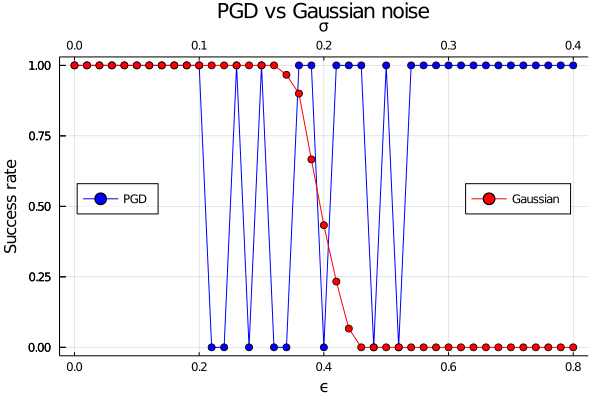

In [48]:
pp = plot(2*es, res_pgd, xlabel="ϵ", ylabel="Success rate", marker=:circle, color=:blue, label="PGD", 
    legend=:left, title="PGD vs Gaussian noise")
p = twiny()
plot!(p, es, res_wn, xlabel="σ", marker=:circle, color=:red, label="Gaussian", legend=:right)
#plot!(2*es, nancurve, marker=(:x, 5, :black), label=nothing, line=nothing, ylim=(-0.05,1.05))

In [49]:
savefig(pp, "figures/pgdvsgaussianfuruta.svg")

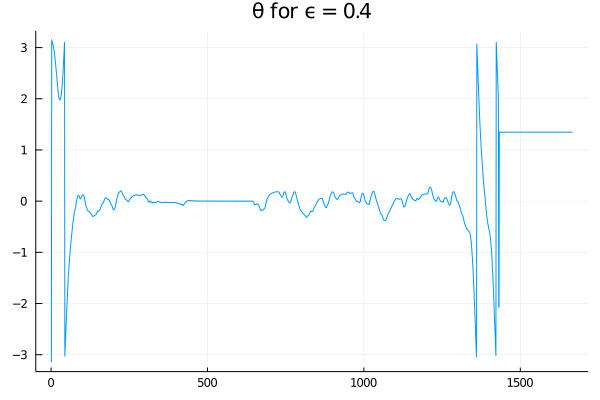

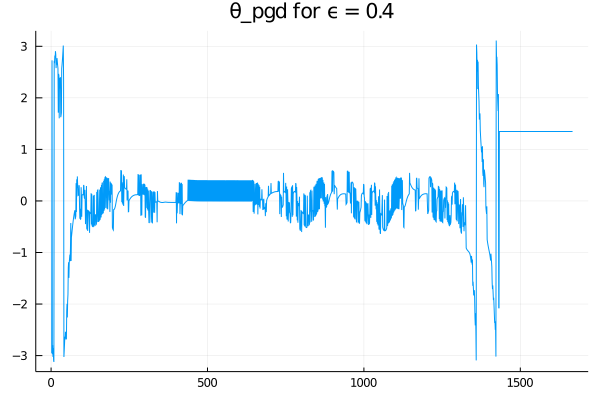

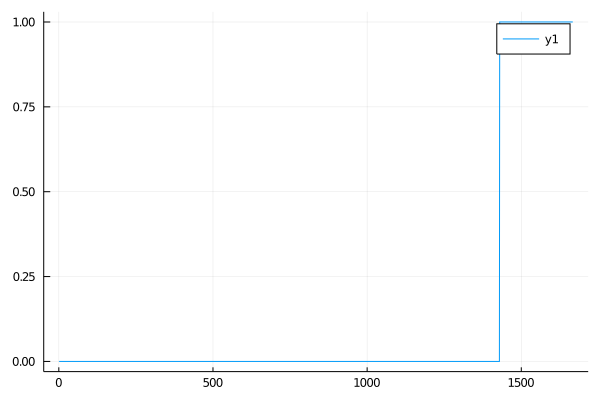

1.3470949

In [57]:
reset!(env.env, [π, 0, 0, 0])
t, done = 0, false
X_pgd = []
X = []
c_reward = 0
nans = []
while !done && t <= 833*2
    s0 = env.env.state 
    push!(X, s0)
    s0 = pgd(agent, s0, ϵ=0.4, steps=10)
    push!(X_pgd, s0)
    s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
    a = action(agent, s; training=false)
    env(a)
    t += 1
    c_reward += reward(env)
    push!(nans, isnan(s0[1]))
end
θ = [rem2pi(x[1], RoundNearest) for x in X]
θ_pgd = [rem2pi(x[1], RoundNearest) for x in X_pgd]
display(plot(θ, title="θ for ϵ = 0.4", label=nothing))
display(plot(θ_pgd, title="θ_pgd for ϵ = 0.4", label=nothing))
display(plot(nans))


In [60]:
print(θ[1500])

1.3470949

In [2]:
Ls = []
perfs = []
push!(Ls, [52.1, 50.01, 30.46, 38.34, 63.66])
push!(perfs, [0.5101, 0.6344, 0.5645, 0.2570, 0.3430])
push!(Ls, [29.05, 33.57, 61.80, 45.88, 28.65])
push!(perfs, [0.2882, 0.5570, 0.3688, 0.5032, 0.6226])
push!(Ls, [46.60, 43.16, 63.78, 45.88, 28.65])
push!(perfs, [0.3860, 0.7301, 0.1355, 0.3677, 0.5731])
push!(Ls, [36.89, 35.79, 55.74, 47.75, 26.44])
push!(perfs, [0.5849, 0.6430, 0.6140, 0.5075, 0.5301])
push!(Ls, [52.37, 38.95, 49.87, 38.67, 36.33])
push!(perfs, [0.5602, 0.5871, 0.2914, 0.4935, 0.4796])
push!(Ls, [42.83, 21.84, 71.04, 55.36, 28.83])
push!(perfs, [0.5882, 0.5806, 0.1215, 0.4580, 0.4785])

6-element Array{Any,1}:
 [0.5101, 0.6344, 0.5645, 0.257, 0.343]
 [0.2882, 0.557, 0.3688, 0.5032, 0.6226]
 [0.386, 0.7301, 0.1355, 0.3677, 0.5731]
 [0.5849, 0.643, 0.614, 0.5075, 0.5301]
 [0.5602, 0.5871, 0.2914, 0.4935, 0.4796]
 [0.5882, 0.5806, 0.1215, 0.458, 0.4785]

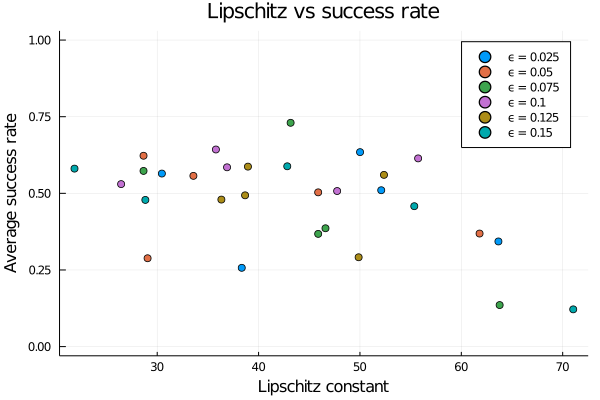

In [14]:
scatter(Ls, perfs, 
    labels=["ϵ = 0.025" "ϵ = 0.05" "ϵ = 0.075" "ϵ = 0.1" "ϵ = 0.125" "ϵ = 0.15"],
    colors=[:green4 :purple4 :yellow3 :azure4 :pink4 :brown4], 
    ylim=[0, 1], xlabel="Lipschitz constant", ylabel="Average success rate", 
    title="Lipschitz vs success rate")

In [15]:
savefig("figures/Lipschitzvssuccess.svg")